In [1]:
#%matplotlib inline

# %load_ext autoreload
# %autoreload 2

import time
import os
import logging
#from functools import wraps
from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pickle
#from tqdm.autonotebook import tqdm, trange

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

from pydmd import DMD, BOPDMD

# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from torch.nn.functional import mse_loss, l1_loss
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary


#import torch.nn.functional as F

FILENAME = 'SIC_dec_retrain_'

# logging.basicConfig(
#     level=logging.DEBUG,
#     format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
#     handlers=[
#         logging.FileHandler("logs/"+FILENAME+"_" + time.strftime("%Y%m%d-%H%M%S")+ ".txt"),
#         #logging.StreamHandler()  #logs to console as well
#     ]
# )

# # Create a logger
# logger = logging.getLogger(__name__)

#import custom modules
if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

# if '../src/modules/' not in sys.path:
#     sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from autoenc_lowres import Encoder, Decoder, MLP_enc_SIC, MLP_dec_SIC
from autoenc_highres import Encoder_sharp, Decoder_sharp, Encoder_sharp_1024, Decoder_sharp_1024
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

In [2]:
#seed for repeatable results
torch.manual_seed(0)

gen1 = torch.Generator().manual_seed(0)

imported_enc = Encoder_sharp_1024
imported_dec = Decoder_sharp_1024  # encoder/decoder to be run

epochs = 1300 #400

# if training needs to be run
run_training = True

run_sharp = True

clamp_yn = True
norm_yn = False

if not run_sharp:
    lowres = 'lowres_'
else:
    lowres = 'sharp_'

if not run_training:
    load_ext = True
    ext_model_dec = '../outputs/latent_space_verification/dec_lowres_64_1000_20240806-134826'
else:
    load_ext = False

In [3]:
sic_data, m = get_ice_data()

if not run_sharp:
    sic_data,_ = thin_data(sic_data,m,3)
del m

#check data with a plot
# fig_1, ax_1 = plt.subplots(figsize=(5,4))
# ax_1.contourf(sic_data[30][350], cmap=plt.get_cmap('Blues_r'))
# ax_1.set_ylim(314, 0)
# fig_1.show()

#check thinned data with a plot
# plt.contourf(DATA[30][350], cmap=plt.get_cmap('Blues_r'))
# plt.show()

In [4]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 710  #215 #batch size for dataloader will vary PC to PC
dim_latent = 64 #2,4,8,16,24,32,
T_test = 365*2
#have run [64]

train_split = int(num_year_data*0.8) * 365
val_split = num_year_data *365 - train_split



# X0_ = get_days_before(DATA, year, day, T_train+window-1) # get days from DATA
# X1_ = get_days_after(DATA, year, day,T_test)

# if window > 1:
#     X0_ = window_mean(X0_, window = window, t = None) # compute window mean, 
#     X1_ = get_test_set(DATA, year, day, window, T_test)

# X0_.shape, X1_.shape

X0_ = get_days_before(sic_data, year, day, T_train+window-1)

all_data = torch.Tensor(X0_)[:,None,:,:]

#mask_tensor = torch.Tensor(np.tile(mask, (X0_.shape[0],1,1,1))).bool()

X1_ = get_days_after(sic_data, year, day,  365*2)

#all_test_data = torch.Tensor(X1_)[:,None,:,:]

#all_data_train, all_data_val = torch.utils.data.random_split(all_data, [train_split, val_split], generator=gen1)

#full_all_data = torch.utils.data.ConcatDataset([all_data, v2.functional.vflip(all_data), v2.functional.hflip(all_data)])
#full_data_train, full_data_val = torch.utils.data.random_split(full_all_data, [train_split*3, val_split*3], generator=gen1)

In [5]:
pretrained_enc = imported_enc(d_latent=dim_latent)
dec = imported_dec(d_latent=dim_latent)

optimal_enc = '../outputs/final/enc_sharp_64_1291_optimal_20240818'

optimal_dec = '../outputs/final/dec_sharp_64_1291_optimal_20240818'

pretrained_enc = torch.load(optimal_enc)
dec = torch.load(optimal_dec)

#import decoder
pretrained_enc.eval()
pretrained_enc = pretrained_enc.cpu() 
pretrained_enc.eval()

if torch.cuda.is_available():
    dec.to("cuda")  

In [6]:
encoded_sic = []

dmdrank = 5
#num_year_data = 4

dmdwindow = 365* 2

# train_split = int(num_year_data*0.8) * 365
# val_split = num_year_data *365 - train_split

train_loader_sic = torch.utils.data.DataLoader(dataset=all_data, batch_size=dmdwindow, shuffle=False)

for i in train_loader_sic: 

    #temp = trained_enc(i.to("cuda"))
    temp = pretrained_enc(i)
    latent_bopdmd = BOPDMD(svd_rank=dmdrank, eig_constraints={
                                "stable", # choose Re(lambda)<0
                                "conjugate_pairs", # force complex conjugate pairs
                                })
    
    latent_bopdmd.fit(temp.detach().numpy().T, t = np.arange(i.shape[0])) 
    encoded_sic.append(latent_bopdmd.reconstructed_data.real.T)

del temp

encoded_sic = np.vstack(encoded_sic)

print(encoded_sic.shape)
decoder_training = TensorDataset (torch.Tensor(encoded_sic),  all_data.squeeze())

all_data_train, all_data_val = torch.utils.data.random_split(decoder_training, [train_split, val_split], generator=gen1)

decoder_training_dl = torch.utils.data.DataLoader(dataset=all_data_train, batch_size=batchSize, shuffle=True)
decoder_validation_dl  = torch.utils.data.DataLoader(dataset=all_data_val, batch_size=batchSize, shuffle=True)

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


(11680, 64)


In [7]:
#a = 

In [8]:
# a1, a2 = decoder_training[0:200]
# dec.eval()
# a3 = dec(a1.to("cuda")).clamp(0,1)

In [9]:
# plt.contourf(a3.squeeze().detach().cpu().numpy()[100])
# plt.show()
# plt.contourf(a2.cpu().numpy()[100])
# plt.show()

In [10]:
def re_train_model(model_dec,epochs, training_dataloader, val_dataloader, 
                autograd, dec_loc, trainloss_loc, valloss_loc,     
                mse_multp = 1.0, mae_multp = 1.0, iiee_multp = 1.0, clamp_img = True, norm_img = False, return_model = False):
    # define loss and parameters
    
    model_dec.train()

    optimiser = autograd(itertools.chain(model_dec.parameters()), lr=0.0001)

    train_loss = []
    val_loss = []

    val_loss_check = 1e10

    t0 = time.time()

    print('====Training start====')
    for epoch in range(epochs):
        
        total_mseloss, total_maeloss, total_iieeloss = 0.0, 0.0, 0.0

        total_val_loss, total_train_loss = 0.0, 0.0
        
        val_loss_mse, val_loss_mae, val_loss_iiee = 0.0, 0.0, 0.0

        for batch_idx, data in enumerate(training_dataloader):
            # prepare input data
            encoding, img = data[0].to("cuda"),  data[1].to("cuda")
            
            output = model_dec(encoding).squeeze()

            if clamp_img == True:
                output_norm = output.clamp(min=0, max= 1)#*mask_tensor
            elif norm_img == True:
                output_norm = normalise_image(output)
            else: 
                output_norm = output
            
            loss_mse = mse_loss(output_norm, img)
            
            loss_mae = l1_loss(img, output_norm)
            
            loss_iiee = torch.sum(batched_iiee(output_norm, img))

            loss = (mse_multp * loss_mse) + (loss_iiee * iiee_multp) + (mae_multp * loss_mae)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Track this epoch's loss
            total_mseloss += loss_mse.item() * data[0].shape[0] / len(all_data_train)
            total_maeloss += loss_mae.item() * data[0].shape[0] / len(all_data_train)
            total_iieeloss += loss_iiee.item() * data[0].shape[0] / len(all_data_train)
            total_train_loss += (loss_mse.item() + loss_mae.item() + loss_iiee.item()) * data[0].shape[0] / len(all_data_train)

        train_loss.append([total_mseloss, total_maeloss ,total_iieeloss, total_train_loss])

        t1 = time.time()

        model_dec.eval()

        with torch.no_grad():
            for batch_idx_val, data_val in enumerate(val_dataloader):
                
                encoding_val, img_val = data_val[0].to("cuda"),  data_val[1].to("cuda")

                output = model_dec(encoding_val).squeeze()

                if clamp_img == True:
                    output_norm = output.clamp(min=0, max= 1)#*mask_tensor
                elif norm_img == True:
                    output_norm = normalise_image(output)
                else: 
                    output_norm = output

                val_loss_mse += mse_loss(output_norm, img_val).item() * data_val[0].shape[0] / len(all_data_val)
                val_loss_mae += l1_loss(output_norm, img_val).item() * data_val[0].shape[0] / len(all_data_val)
                val_loss_iiee += torch.sum(batched_iiee(output_norm, img_val)).item() * data_val[0].shape[0] / len(all_data_val)

                total_val_loss += (
                                    (mse_loss(output_norm, img_val).item() * val_loss_mse) + 
                                    (torch.sum(batched_iiee(output_norm, img_val)).item()  * iiee_multp) + 
                                    (torch.sum(l1_loss(output_norm, img_val)).item()  * mae_multp)
                                  ) * data_val[0].shape[0] / len(all_data_val)

            val_loss.append([val_loss_mse, val_loss_iiee, total_val_loss])


        model_dec.train()

        t2 = time.time()

        #check val error and save model
        if epoch > 0:
            if total_val_loss < val_loss_check:
                torch.save(model_dec, '../' + dec_loc +'intertrain/retrained_dec_'+  lowres + str(dim_latent)+'_'+ str(epoch) +'_optimal_' +  time.strftime("%Y%m%d"))
                
                if os.path.exists('../' + dec_loc +'intertrain/re_intertrain_model_log.txt') == False:
                    open('../' + dec_loc +'intertrain/re_intertrain_model_log.txt', "w").close
                    
                with open('../' + dec_loc +'intertrain/re_intertrain_model_log.txt', "a") as text_file:
                    text_file.write('====> Epoch: {}, Train time: {:.4f}, Val time: {:.4f} \n'.format(epoch, t1-t0, t2-t1))
                    text_file.write('====> Epoch: {} Total loss: {:.4f} MSE Loss: {:.4f} MAE Loss: {:.4f} Val loss: {:.4f} \n'.format(epoch, total_train_loss, total_mseloss, total_maeloss,total_val_loss))
                    text_file.write('../' + dec_loc +'intertrain/retrained_dec_'+  lowres + str(dim_latent)+'_'+ str(epoch) +'_optimal_' +  time.strftime("%Y%m%d")+'\n')
                    text_file.write('\n')
                
                val_loss_check = total_val_loss

        if epoch%10==0:  
            print('====> Epoch: {}, Train time: {:.4f}, Val time: {:.4f}'.format(epoch, t1-t0, t2-t1))
            print('====> Epoch: {} Total loss: {:.4f} MSE Loss: {:.4f} MAE Loss: {:.4f} Val loss: {:.4f}'.format(epoch, total_train_loss, total_mseloss, total_maeloss,total_val_loss))
    
    print('====Training finish====')

    torch.save(model_dec, '../' + dec_loc +'retrained_dec_' + lowres + str(dim_latent)+'_'+ str(epochs) +'_' +  time.strftime("%Y%m%d-%H%M%S"))

    train_loss_np = np.array(train_loss)
    val_loss_np = np.array(val_loss)

    with open('../' + trainloss_loc  + lowres + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(train_loss_np, output)

    with open('../' + valloss_loc  + lowres + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(val_loss_np, output)

    if return_model:
        return model_dec, train_loss , val_loss

In [11]:
if run_training:

    dec, trainloss,valloss = re_train_model(
        model_dec = dec,
        epochs = epochs, 
        training_dataloader = decoder_training_dl, 
        val_dataloader = decoder_validation_dl,
        autograd = optim.AdamW, 
        #enc_loc = 'outputs/latent_space_verification/',
        #dec_loc = 'outputs/latent_space_verification/' , 
        dec_loc = 'outputs/final/' , 
        # trainloss_loc = 'outputs/latent_space_verification/train_loss_', 
        # valloss_loc = 'outputs/latent_space_verification/val_loss' , 
        trainloss_loc = 'outputs/final/re_train_loss_', 
        valloss_loc = 'outputs/final/re_val_loss_' , 
        mse_multp = 0.0, mae_multp = 1.0, iiee_multp = 1.0,
        clamp_img= clamp_yn,
        norm_img= norm_yn,
        return_model = True
    )

====Training start====


c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\torch\nn\modules\conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv_transpose2d(


====> Epoch: 0, Train time: 14.6463, Val time: 1.1705
====> Epoch: 0 Total loss: 2013750.5863 MSE Loss: 0.0114 MAE Loss: 0.0308 Val loss: 1799419.9288
====> Epoch: 10, Train time: 144.6028, Val time: 1.0315
====> Epoch: 10 Total loss: 1832485.2120 MSE Loss: 0.0099 MAE Loss: 0.0279 Val loss: 1716779.1807
====> Epoch: 20, Train time: 271.7727, Val time: 1.0186
====> Epoch: 20 Total loss: 1775915.4415 MSE Loss: 0.0094 MAE Loss: 0.0271 Val loss: 1657152.4191
====> Epoch: 30, Train time: 399.3486, Val time: 1.0291
====> Epoch: 30 Total loss: 1752812.1063 MSE Loss: 0.0093 MAE Loss: 0.0268 Val loss: 1646739.8976
====> Epoch: 40, Train time: 526.6297, Val time: 1.0337
====> Epoch: 40 Total loss: 1736046.3098 MSE Loss: 0.0092 MAE Loss: 0.0267 Val loss: 1636811.1738
====> Epoch: 50, Train time: 653.7638, Val time: 1.0241
====> Epoch: 50 Total loss: 1707569.6873 MSE Loss: 0.0089 MAE Loss: 0.0263 Val loss: 1769568.6968
====> Epoch: 60, Train time: 780.8107, Val time: 1.0114
====> Epoch: 60 Total l

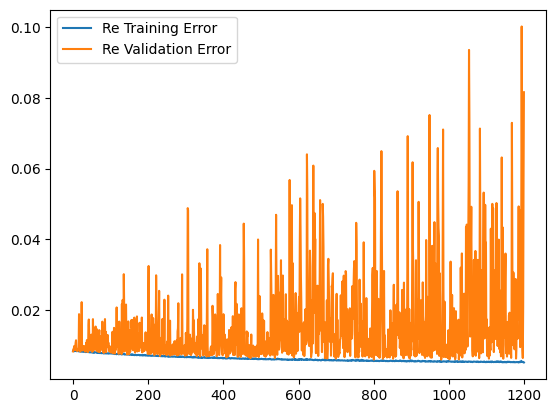

In [12]:
if run_training:
    # collect loss and add plot 
    plt.plot(np.array(trainloss)[100:,0], label = "Re Training Error")
        # plt.legend()
        # plt.show()
    plt.plot(np.array(valloss)[100:,0], label = "Re Validation Error")
    plt.legend()
    plt.show()

# with open(r'C:\Project\smooth_autoenc\outputs\latent_space_verification\trainloss_lowres_2_1000_20240726-115656', 'rb') as f:
#     train_loss_pkl = pickle.load(f)

# with open(r'C:\Project\smooth_autoenc\outputs\latent_space_verification\vallosslowres_2_1000_20240726-115656', 'rb') as f:
#     val_loss_pkl = pickle.load(f)

# plt.plot(train_loss_pkl[100:,0], label = "Training Error")
# plt.plot(val_loss_pkl[100:,0], label = "Validation Error")
# plt.legend()
# plt.show()

In [13]:
## load models ###
if load_ext:
    trained_dec = imported_dec()

    trained_dec = torch.load(model_dec)
else:
    trained_dec = dec

dec.eval()

trained_dec.eval()

trained_dec_cpu = trained_dec.cpu()

In [14]:
def test_data_stats(test_data,clamp_yn, norm_yn, encoder, decorder):

    X_test_all = torch.Tensor(test_data)[:,None,...]

    enc_test = encoder(X_test_all)

    if clamp_yn == True:
        dec_test = decorder(enc_test).clamp(min=0, max= 1)
    elif norm_yn == True:
        dec_test = normalise_image(decorder(enc_test))#*mask_tensor[:730,:,:,:])
    else:
        dec_test = decorder(enc_test)
         
    X_test, dec_test = X_test_all.permute(1,0,2,3)[0], dec_test.permute(1,0,2,3)[0]

    x_true, x_predict = X_test.flatten(), dec_test.flatten()

    err = (x_true - x_predict)**2

    mse_per_img = ((dec_test - X_test)**2).sum(dim=(1,2))/(X_test.shape[2]**2)

    mae_per_img = (torch.abs(dec_test - X_test)).sum(dim=(1,2))/(X_test.shape[2]**2)

    total_err =  err.sum().detach().numpy()
    
    avg_err = total_err/err.shape[0]

    avg_mae = mae_per_img.sum()/mae_per_img.shape[0]

    print("Total square error: {:.4f}, MSE: {:.4f} RMSE: {:.4f}".format(total_err,avg_err, np.sqrt(avg_err)))

    #iiee
    test_iiee = iiee_calc(dec_test, X_test)
    
    iiee_per_img = batched_iiee(dec_test, X_test)

    print("Total iiee: {:.4f}".format(test_iiee))

    return [err,  total_err, avg_err, np.sqrt(avg_err), mse_per_img, mae_per_img, avg_mae, test_iiee, iiee_per_img]

In [15]:
test_loss_tuple = test_data_stats(X1_,clamp_yn,norm_yn,trained_enc_cpu, trained_dec_cpu)

# with open('../outputs/latent_space_verification/test_loss_'+ lowres   + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
#         pickle.dump(test_loss_tuple, output)

with open('../outputs/final/test_loss_'+ lowres   + str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(test_loss_tuple, output)

NameError: name 'trained_enc_cpu' is not defined

In [ ]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [ ]:
enc_test = trained_enc_cpu(torch.Tensor(X1_)[:,None,:,:])
dec_test = trained_dec_cpu(enc_test).clamp(0,1)
dec_test_arr = dec_test.permute(1,0,2,3).detach().numpy()[0]

In [ ]:
contour_compare(X1_, dec_test_arr)

In [ ]:
# enc_train = trained_enc_cpu(all_data)
# dec_train = trained_dec_cpu(enc_train)#.clamp(0,1)
# dec_train_arr = dec_train.permute(1,0,2,3).detach().numpy()[0]

In [ ]:
# contour_compare(X0_, dec_train_arr)

In [ ]:
mse_perimage_chck = ((dec_test_arr - X1_)**2).sum(axis=(1,2))/(X1_.shape[2]**2)

mse_avg_chk = mse_perimage_chck.sum()/X1_.shape[0]
mse_avg_chk

plt.plot(mse_perimage_chck)
plt.show()

iiee_chck = batched_iiee(torch.Tensor(dec_test_arr), torch.Tensor(X1_))

plt.plot(iiee_chck)
plt.show()